<a href="https://colab.research.google.com/github/pinatics/datacution/blob/master/VAE_German_Credit_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoder (VAE) Analysis on German Credit Dataset Using Google Colab**
This guide walks you through the process of performing Variational Autoencoder (VAE) analysis on the German credit dataset using TensorFlow and Keras in a Google Colab environment. using Google Colab. It covers data preprocessing, building the VAE model, training, and visualizing the results—all within the Colab environment.


### Project Objectives
- Understand the dataset structure
- Preprocess the dataset
- Build and train a VAE model
- Visualize the results

This project is designed as part of my resume projects, showcasing VAE's capabilities in analyzing financial data.


In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import tensorflow as tf  # For building and training the VAE model
from tensorflow.keras.layers import Input, Dense, Lambda  # Layers for creating the VAE
from tensorflow.keras.models import Model  # Model class to define the VAE
from tensorflow.keras import backend as K  # Keras backend for defining custom functions
from sklearn.preprocessing import StandardScaler  # For data normalization
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and test sets
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For more attractive data visualization
sns.set(style='whitegrid')  # Set the seaborn style

print('Libraries imported successfully.')

Libraries imported successfully.


### Step 1: Load the Dataset
The German Credit dataset can be found on the UCI Machine Learning Repository. We will load this dataset into a pandas DataFrame and display the first few rows to understand its structure.
- The `read_csv` function is used to load the data.
- We define appropriate column names based on the dataset documentation.

In [2]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
columns = ['Status', 'Duration', 'Credit_history', 'Purpose', 'Credit_amount', 'Savings',
           'Employment', 'Installment_rate', 'Personal_status', 'Other_debtors', 'Residence_since',
           'Property', 'Age', 'Other_installment_plans', 'Housing', 'Existing_credits', 'Job',
           'Num_dependents', 'Telephone', 'Foreign_worker', 'Target']
df = pd.read_csv(url, delimiter=' ', header=None, names=columns)

# Display the first few rows of the dataset
df.head()

,Status,Duration,Credit_history,Purpose,Credit_amount,Savings,Employment,Installment_rate,Personal_status,Other_debtors,...,Property,Age,Other_installment_plans,Housing,Existing_credits,Job,Num_dependents,Telephone,Foreign_worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Step 2: Data Preprocessing
Data preprocessing involves transforming raw data into an understandable format:
- **Encoding categorical variables**: Converting categorical columns into numerical values using one-hot encoding.
- **Standardizing the data**: Using `StandardScaler` to ensure all features have a mean of 0 and a standard deviation of 1.
- **Splitting the dataset**: Dividing the data into training and test sets to evaluate model performance.

In [3]:
# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, drop_first=True)  # Convert categorical features to numerical

# Standardize the data
scaler = StandardScaler()  # Create a StandardScaler object
df_scaled = scaler.fit_transform(df.drop(columns=['Target']))  # Fit and transform the data

# Split the data into training and testing sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)  # 80% training, 20% testing
print('Data preprocessing completed.')

Data preprocessing completed.


### Step 3: Build the VAE Model
The Variational Autoencoder (VAE) has three main components:
- **Encoder**: Compresses the input data into a lower-dimensional representation.
- **Latent Space Sampling**: Uses a reparameterization trick to introduce stochasticity in learning.
- **Decoder**: Reconstructs the input data from the compressed representation.

In [4]:
# Define the VAE architecture
original_dim = X_train.shape[1]  # The number of features in the input data
input_shape = (original_dim, )  # Input shape of the model
latent_dim = 2  # Number of dimensions for the latent space
intermediate_dim = 64  # Number of neurons in the hidden layer

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')  # Define the input layer
h = Dense(intermediate_dim, activation='relu')(inputs)  # Hidden layer with ReLU activation
z_mean = Dense(latent_dim, name='z_mean')(h)  # Latent mean layer
z_log_var = Dense(latent_dim, name='z_log_var')(h)  # Latent log variance layer

# Sampling function using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_var) * epsilon  # Combine mean, variance, and noise

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  # Latent vector

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')  # Hidden layer for the decoder
decoder_mean = Dense(original_dim, activation='sigmoid')  # Output layer with sigmoid activation
h_decoded = decoder_h(z)  # Apply hidden layer
x_decoded_mean = decoder_mean(h_decoded)  # Output reconstructed data

# VAE model
vae = Model(inputs, x_decoded_mean)  # Define the full VAE model
print('VAE model defined.')

VAE model defined.


### Step 4: Define the VAE Loss Function
The loss function for a VAE is composed of two parts:
- Reconstruction loss: Measures how well the decoder is able to reconstruct the input data
- KL Divergence loss: Regularizes the latent space to ensure it approximates a normal distribution
The total VAE loss is a combination of these two components.

In [8]:
# Define a custom layer for calculating the loss
from tensorflow.keras.layers import Layer

class VAELossLayer(Layer):
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs

        # Flatten the tensors
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_decoded_mean))

        # KL divergence
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

        # Combine the reconstruction and KL divergence losses
        vae_loss = reconstruction_loss + kl_loss

        # Add the loss to the model
        self.add_loss(vae_loss)
        return x_decoded_mean

# Adding the custom loss layer into the model
outputs = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])
vae = Model(inputs, outputs)

# Compile the model (no need to pass a separate loss function here since it's handled by the custom layer)
vae.compile(optimizer='adam')
print('VAE model compiled with integrated custom loss function.')

VAE model compiled with integrated custom loss function.


### Step 5: Train the VAE Model
We will train the model using the training data for a specified number of epochs. The loss function values will help us evaluate how well the model is learning.

In [10]:
# Train the VAE model
history = vae.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))
print('Training completed.')


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -45.9792 - val_loss: -39.3614
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -45.0372 - val_loss: -40.8767
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -43.7740 - val_loss: -40.5995
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -45.0373 - val_loss: -41.5227
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -46.6641 - val_loss: -42.5072
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -45.5686 - val_loss: -42.8558
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -48.0010 - val_loss: -43.5825
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: -48.2530 - val_loss: -44.7127
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: -48.5552 - val_loss: -43.4057
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -50.5594 - val_loss: -44.8753
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -52.4237 - val_loss: -44.8548
Epoch 12/50
25/25 ━━━━━━━━━━━

### Step 6: Visualize Training Loss
We'll plot the training and validation loss over the epochs to see how well the model converges.

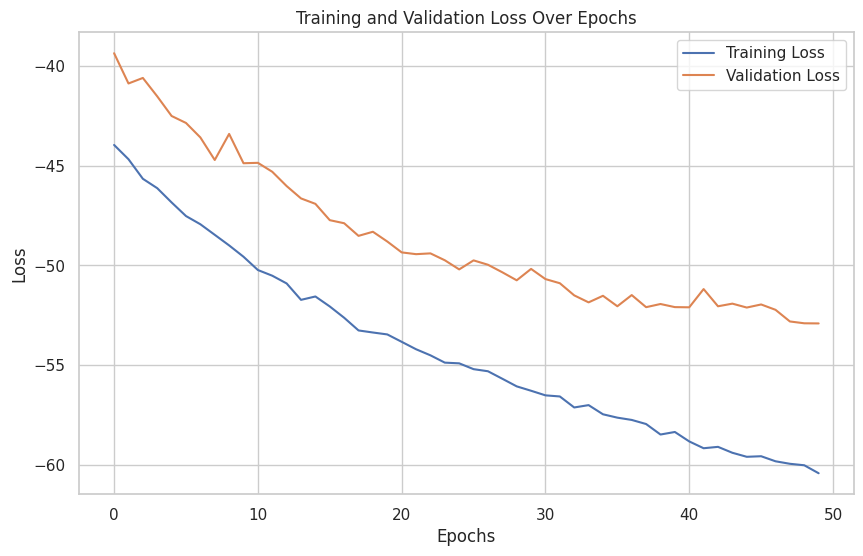

In [11]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Step 7: Visualize Latent Space
By projecting the data into the latent space, we can gain insights into how the VAE represents the data in a lower-dimensional form.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


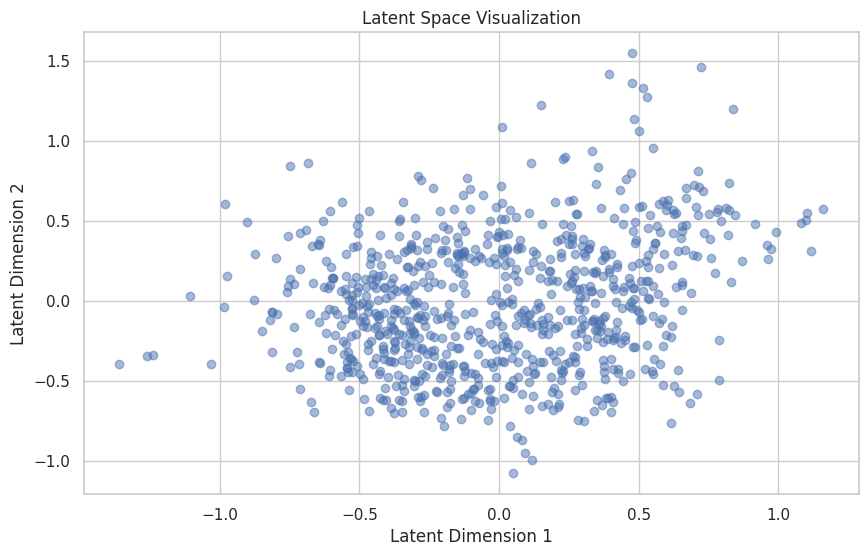

In [12]:
# Define an encoder model to project data into the latent space
encoder = Model(inputs, z_mean)
X_train_encoded = encoder.predict(X_train)

# Visualize the latent space
plt.figure(figsize=(10, 6))
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], alpha=0.5)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

### Step 8: Generate New Samples
Finally, we can use the decoder part of the VAE to generate new synthetic samples from the latent space.

In [13]:
# Define a decoder model
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h(decoder_input)
x_decoded_mean = decoder_mean(h_decoded)
generator = Model(decoder_input, x_decoded_mean)

# Generate new samples by sampling from the latent space
new_samples = generator.predict(np.random.normal(size=(10, latent_dim)))
new_samples_rescaled = scaler.inverse_transform(new_samples)
print('Generated new samples:', new_samples_rescaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Generated new samples: [[2.14103031e+01 3.66927002e+03 2.97300005e+00 2.84501386e+00
  3.55460129e+01 1.40700030e+00 1.15540576e+00 7.01923072e-01
  1.03697702e-01 3.93999994e-01 2.44410485e-01 5.30000091e-01
  1.03152104e-01 2.93000013e-01 1.03000000e-01 3.96890789e-02
  1.80999994e-01 2.80000001e-01 1.20003922e-02 1.28361240e-01
  5.00000007e-02 9.57446843e-02 2.28531882e-01 4.05856907e-01
  6.30000010e-02 4.80000041e-02 1.83000118e-01 1.72000006e-01
  3.38999987e-01 5.23642540e-01 2.52999991e-01 3.10000002e-01
  5.53646088e-01 9.20006931e-02 2.26407900e-01 7.88298696e-02
  2.37451777e-01 3.31999987e-01 1.54001012e-01 4.76028845e-02
  8.14000010e-01 7.13026404e-01 1.08000003e-01 2.64812231e-01
  6.29999995e-01 1.48010179e-01 4.04007614e-01 1.30020052e-01]
 [2.73079243e+01 5.87231592e+03 2.97300005e+00 2.84509182e+00
  3.55460815e+01 1.40700042e+00 1.15735221e+00 7.06893325e-01
  8.51960182e-02 3.93999994e-01 2.62725085e-01 5.29999971e-01
  1.3371

## Conclusion
In this project, we successfully implemented a Variational Autoencoder (VAE) on the German Credit Dataset, explored the latent space, and generated new samples. This demonstrates the potential of VAEs in understanding complex datasets and generating synthetic data.